# Probit Model (EP)

In [1]:
# Activate local environment, see `Project.toml`
import Pkg; Pkg.activate(".."); Pkg.instantiate(); 

  Activating project at `~/.julia/dev/RxInfer/examples`
     Cloning git-repo `https://github.com/ReactiveBayes/GraphPPL.jl`
     Cloning git-repo `https://github.com/ReactiveBayes/RxInfer.jl`
     Cloning git-repo `https://github.com/ReactiveBayes/ReactiveMP.jl`
   Installed prrte_jll ─────── v3.0.2+0
   Installed libevent_jll ──── v2.1.13+1
   Installed PMIx_jll ──────── v4.2.7+0
   Installed ArnoldiMethod ─── v0.2.0
   Installed MetaGraphsNext ── v0.7.0
   Installed JLD2 ──────────── v0.4.46
   Installed OpenMPI_jll ───── v5.0.2+0
   Installed HDF5_jll ──────── v1.14.2+1
   Installed Inflate ───────── v0.1.4
   Installed ArrayLayouts ──── v1.8.0
   Installed LLVM ──────────── v6.6.2
   Installed Graphs ────────── v1.9.0
   Installed BitSetTuples ──── v1.1.5
   Installed Indexing ──────── v1.1.1
   Installed NamedTupleTools ─ v0.14.3
   Installed Dictionaries ──── v0.4.1
Precompiling project...
  ✓ BitSetTuples
  ✓ Indexing
  ✓ NamedTupleTools
  ✓ Inflate
  ✓ libevent_jll
  ✓ Arnoldi

`RxInfer` comes with support for expectation propagation (EP). In this demo we illustrate EP in the context of state-estimation in a linear state-space model that combines a Gaussian state-evolution model with a discrete observation model. Here, the probit function links continuous variable $x_t$ with the discrete variable $y_t$. The model is defined as:

$$\begin{aligned}
    u &= 0.1 \\
    x_0 &\sim \mathcal{N}(0, 100) \\
    x_t &\sim \mathcal{N}(x_{t-1}+ u, 0.01) \\
    y_t &\sim \mathrm{Ber}(\Phi(x_t))
\end{aligned}$$

## Import packages

In [15]:
Pkg.status()
using RxInfer, GraphPPL,StableRNGs, Random, Plots, Distributions
using StatsFuns: normcdf

Status `~/.julia/dev/RxInfer/examples/Project.toml`
  [b4ee3484] BayesBase v1.2.1
  [6e4b80f9] BenchmarkTools v1.5.0
  [336ed68f] CSV v0.10.13
  [a93c6f00] DataFrames v1.6.1
  [31c24e10] Distributions v0.25.107
  [62312e5e] ExponentialFamily v1.4.1
⌃ [587475ba] Flux v0.14.11
  [38e38edf] GLM v1.9.0
  [b3f8163a] GraphPPL v4.0.0 `https://github.com/ReactiveBayes/GraphPPL.jl#dev-4.0.0-examples`
  [34004b35] HypergeometricFunctions v0.3.23
  [7073ff75] IJulia v1.24.2
  [4138dd39] JLD v0.13.5
  [b964fa9f] LaTeXStrings v1.3.1
  [429524aa] Optim v1.9.4
⌃ [3bd65402] Optimisers v0.2.20
  [d96e819e] Parameters v0.12.3
  [91a5bcdd] Plots v1.40.3
  [92933f4c] ProgressMeter v1.10.0
  [a194aa59] ReactiveMP v3.13.3 `https://github.com/ReactiveBayes/ReactiveMP.jl#dev-4.0.0-examples`
  [37e2e3b7] ReverseDiff v1.15.1
  [df971d30] Rocket v1.7.4
  [86711068] RxInfer v2.16.1 `https://github.com/ReactiveBayes/RxInfer.jl#dev-4.0.0-examples`
  [276daf66] SpecialFunctions v2.3.1
  [860ef19b] StableRNGs v1.0.1


##  Data generation

In [10]:
function generate_data(nr_samples::Int64; seed = 123)
    
    rng = StableRNG(seed)
    
    # hyper parameters
    u = 0.1

    # allocate space for data
    data_x = zeros(nr_samples + 1)
    data_y = zeros(nr_samples)
    
    # initialize data
    data_x[1] = -2
    
    # generate data
    for k in eachindex(data_y)
        
        # calculate new x
        data_x[k+1] = data_x[k] + u + sqrt(0.01)*randn(rng)
        
        # calculate y
        data_y[k] = normcdf(data_x[k+1]) > rand(rng)
        
    end
    
    # return data
    return data_x, data_y
    
end;

In [8]:
n = 40

40

In [11]:
data_x, data_y = generate_data(n);

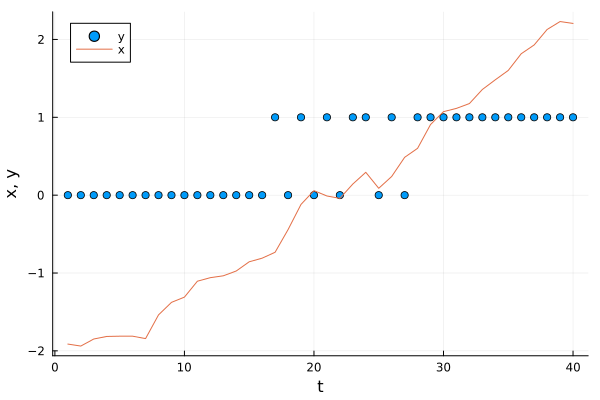

In [12]:
p = plot(xlabel = "t", ylabel = "x, y")
p = scatter!(p, data_y, label = "y")
p = plot!(p, data_x[2:end], label = "x")

## Model specification

In [20]:
@model function probit_model(y::Vector{Int64}, prior_x)
    
    # specify uninformative prior
    x_prev ~ prior_x
    
    # create model 
    for k in eachindex(y)
        x[k] ~ Normal(mean = x_prev + 0.1, precision = 100)
        y[k] ~ Probit(x[k]) where {
            # Probit node by default uses RequireMessage pipeline with vague(NormalMeanPrecision) message as initial value for `in` edge
            # To change initial value use may specify it manually, like. Changes to the initial message may improve stability in some situations
            pipeline = RequireMessage(in = NormalMeanPrecision(0, 0.01)) 
        }
        x_prev = x[k]
    end
    
end;

┌ Warning: Type annotation found in interface y::Vector{Int64}. While this will check that y is an Vector{Int64}, dynamic creation of submodels using multiple dispatch is not supported.
└ @ GraphPPL /Users/raphaeltresor/.julia/packages/GraphPPL/wg1xf/src/model_macro.jl:683


## Inference

In [22]:
result = infer(
    model = probit_model(y=length(data_y),prior_x=Normal(0.0, 0.01)), 
    data  = (y = data_y, ), 
    iterations = 5, 
    returnvars = (x = KeepLast(),),
    free_energy  = true
)

ErrorException: Fixed keys in the `ModelGenerator` should not intersect with the extra keyword arguments in (y = GraphPPL.LazyNodeLabel{GraphPPL.NodeCreationOptions{@NamedTuple{kind::Symbol, factorized::Bool}}, Vector{Float64}}(GraphPPL.Model{MetaGraphsNext.MetaGraph{Int64, Graphs.SimpleGraphs.SimpleGraph{Int64}, GraphPPL.NodeLabel, GraphPPL.NodeData, GraphPPL.EdgeLabel, GraphPPL.Context, MetaGraphsNext.var"#4#8", Float64}, GraphPPL.PluginsCollection{Tuple{GraphPPL.VariationalConstraintsPlugin{GraphPPL.Constraints{Tuple{}, Tuple{}, Tuple{}, @NamedTuple{}, @NamedTuple{}}}, GraphPPL.MetaPlugin{GraphPPL.MetaSpecification}, RxInfer.ReactiveMPInferencePlugin{RxInfer.ReactiveMPInferenceOptions{Nothing, Nothing}}, RxInfer.ReactiveMPFreeEnergyPlugin{RxInfer.BetheFreeEnergy{Real, SkipInitial, AsapScheduler}}}}, RxInfer.ReactiveMPGraphPPLBackend}(Meta graph based on a Graphs.SimpleGraphs.SimpleGraph{Int64} with vertex labels of type GraphPPL.NodeLabel, vertex metadata of type GraphPPL.NodeData, edge metadata of type GraphPPL.EdgeLabel, graph metadata given by GraphPPL.Context(0, probit_model, "", nothing, {}, {}, {}, {}, {}, {}, {}, Base.RefValue{Any}(#undef)), and default weight 1.0, GraphPPL.PluginsCollection{Tuple{GraphPPL.VariationalConstraintsPlugin{GraphPPL.Constraints{Tuple{}, Tuple{}, Tuple{}, @NamedTuple{}, @NamedTuple{}}}, GraphPPL.MetaPlugin{GraphPPL.MetaSpecification}, RxInfer.ReactiveMPInferencePlugin{RxInfer.ReactiveMPInferenceOptions{Nothing, Nothing}}, RxInfer.ReactiveMPFreeEnergyPlugin{RxInfer.BetheFreeEnergy{Real, SkipInitial, AsapScheduler}}}}((GraphPPL.VariationalConstraintsPlugin{GraphPPL.Constraints{Tuple{}, Tuple{}, Tuple{}, @NamedTuple{}, @NamedTuple{}}}(Constraints: 
), GraphPPL.MetaPlugin{GraphPPL.MetaSpecification}(GraphPPL.MetaSpecification(GraphPPL.MetaObject[], Union{GraphPPL.GeneralSubModelMeta, GraphPPL.SpecificSubModelMeta}[])), RxInfer.ReactiveMPInferencePlugin{RxInfer.ReactiveMPInferenceOptions{Nothing, Nothing}}(RxInfer.ReactiveMPInferenceOptions{Nothing, Nothing}(nothing, nothing, true)), RxInfer.ReactiveMPFreeEnergyPlugin{RxInfer.BetheFreeEnergy{Real, SkipInitial, AsapScheduler}}(RxInfer.BetheFreeEnergy{Real, SkipInitial, AsapScheduler}(SkipInitial(), AsapScheduler())))), RxInfer.ReactiveMPGraphPPLBackend(), Base.RefValue{Int64}(0)), GraphPPL.Context(0, probit_model, "", nothing, {}, {}, {}, {}, {}, {}, {}, Base.RefValue{Any}(#undef)), GraphPPL.NodeCreationOptions{@NamedTuple{kind::Symbol, factorized::Bool}}((kind = :data, factorized = true)), :y, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]),).

## Results

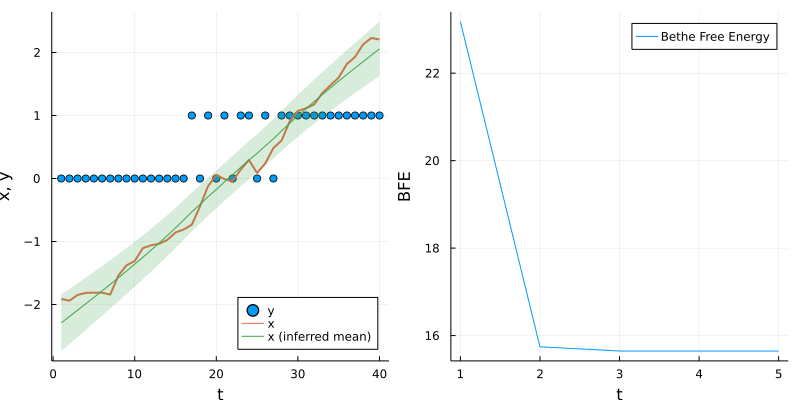

In [9]:
mx = result.posteriors[:x]

p = plot(xlabel = "t", ylabel = "x, y", legend = :bottomright)
p = scatter!(p, data_y, label = "y")
p = plot!(p, data_x[2:end], label = "x", lw = 2)
p = plot!(mean.(mx)[2:end], ribbon = std.(mx)[2:end], fillalpha = 0.2, label="x (inferred mean)")

f = plot(xlabel = "t", ylabel = "BFE")
f = plot!(result.free_energy, label = "Bethe Free Energy")

plot(p, f, size = (800, 400))